## Loading and using a trained model
Notebook demonstrating how to load a JointVAE model and use it for various things.

In [1]:
from utils.load_model import load
import json

path_to_model_folder = './trained_models/mnist/'
path_to_specs = path_to_model_folder + 'specs.json'
# Open specs file
with open(path_to_specs) as specs_file:
    specs = json.load(specs_file)

model = load(path_to_model_folder)

### Look at architecture and latent spec

In [2]:
# Print the latent distribution info
print(model.latent_spec)

{'disc': [10], 'cont': 10}


In [3]:
# Print model architecture
print(model)

VAE(
  (img_to_features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (features_to_hidden): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_mean): Linear(in_features=256, out_features=10, bias=True)
  (fc_log_var): Linear(in_features=256, out_features=10, bias=True)
  (fc_alphas): ModuleList(
    (0): Linear(in_features=256, out_features=10, bias=True)
  )
  (latent_to_features): Sequential(
    (0): Linear(in_features=20, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1024, bias=True)
    (3): ReLU()
  )
  (features_to_img): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv

### Visualize various aspects of the model

In [6]:
from viz.visualize import Visualizer as Viz

# Create a Visualizer for the model
viz = Viz(model,specs,False)
viz.save_images = False  # Return tensors instead of saving images

#### Samples
Plot generated samples from the model

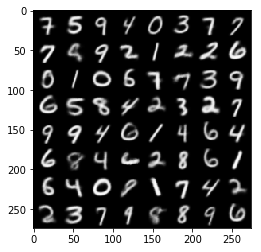

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

samples = viz.samples()
plt.imshow(samples.numpy()[0, :, :], cmap='gray')

#### All latent traversals

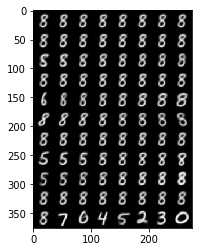

In [17]:
traversals = viz.all_latent_traversals()
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

#### Plot a grid of two interesting traversals

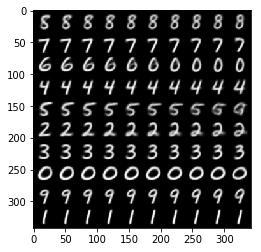

In [9]:
# Traverse 3rd continuous latent dimension across columns and first 
# discrete latent dimension across rows
traversals = viz.latent_traversal_grid(cont_idx=2, cont_axis=1, disc_idx=0, disc_axis=0, size=(10, 10))
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

#### Reorder discrete latent to match order of digits 

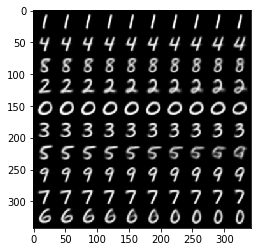

In [10]:
from viz.visualize import reorder_img

ordering = [9, 3, 0, 5, 7, 6, 4, 8, 1, 2]  # The 9th dimension corresponds to 0, the 3rd to 1 etc...
traversals = reorder_img(traversals, ordering, by_row=True)
plt.imshow(traversals.numpy()[0, :, :], cmap='gray')

#### Plot traversal of single dimension

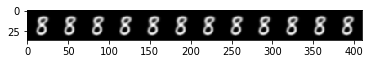

In [11]:
traversal = viz.latent_traversal_line(cont_idx=6, size=12)
plt.imshow(traversal.numpy()[0, :, :], cmap='gray')

#### Plot reconstructions

C:\Users\v-tayan\joint-vae\viz\visualize.py:95: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_data = Variable(data, volatile=True)


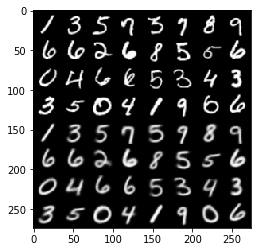

In [11]:
from utils.dataloaders import get_mnist_dataloaders

# Get MNIST test data
_, dataloader = get_mnist_dataloaders(batch_size=32)

# Extract a batch of data
for batch, labels in dataloader:
    break
    
recon = viz.reconstructions(batch, size=(8, 8))

plt.imshow(recon.numpy()[0, :, :], cmap='gray')

### Encode data
The model can also be used to get encodings of the data

In [12]:
from torch.autograd import Variable
encodings = model.encode(Variable(batch))

In [13]:
# Continuous encodings for the first 5 examples
encodings['cont'][0][:5]

tensor([[-0.0059, -0.0122, -0.1028, -0.0126, -0.0051,  0.7394,  0.2665, -0.0006,
         -1.4073,  0.1114],
        [-0.0107, -0.0236,  0.8940, -0.0340, -0.0324,  0.6077, -1.6873,  0.0094,
          0.2221, -0.3998],
        [-0.0070, -0.0191, -0.5002, -0.0110, -0.0151, -0.9261, -1.0872, -0.0193,
          0.2276,  0.1109],
        [-0.0028, -0.0034, -0.9942, -0.0081,  0.0120, -0.0528, -0.8408, -0.0022,
          0.9452,  0.8918],
        [-0.0316, -0.0230, -0.7126, -0.0120, -0.0294,  0.0362, -1.0899, -0.0296,
          1.4742,  0.9038]], grad_fn=<SliceBackward>)

In [12]:
# Plot a grid of some traversals
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch
path_to_data='../data'
all_transforms = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor()
    ])
test_data = datasets.MNIST(path_to_data, train=False,
                               transform=all_transforms)
test_loader = DataLoader(test_data, batch_size=10000, shuffle=True)
for data in test_loader:
    pass
imges = data[0]
label = data[1]

In [13]:
latent_dist = model.encode(imges)
_, predict_label = torch.max(latent_dist['disc'][0], dim=1)
confusion = torch.zeros(10, 10)
for i in range(10000):
    confusion[label[i].item(),predict_label[i].item()] += 1
for i in range(10):
    confusion[i] = confusion[i] / confusion[i].sum()

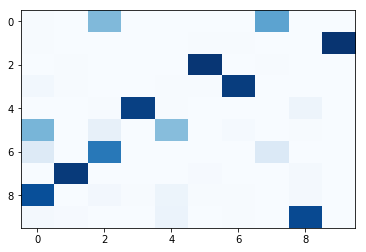

In [14]:
# confusion = np.array([[0.9,0.1,0.0],[0.0,0.8,0.2],[0.1,0.7,0.2]])
# confusion = torch.tensor(confusion)
from matplotlib import cm
plt.imshow(confusion,interpolation='nearest',cmap=cm.Blues,aspect='auto',vmin=0,vmax=1.0)

In [15]:
value, predict_label = torch.max(confusion, dim=1)

In [16]:
value.mean()

tensor(0.8311)